In [1]:
import pandas as pd
import nltk
import os
import string
import re
import gensim
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from datetime import datetime
from collections import Counter
from nltk import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [6]:
os.chdir('c:/users/lzc/desktop/Thumbtack/data')
plt.rcParams['figure.figsize']=(12,10)

In [7]:
files=os.listdir()

In [8]:
files

['SLC Landscaping - Requests, Quotes, and Customer Support Contacts -- Jan-Oct 2018 - customer_support_cases.csv',
 'SLC Landscaping - Requests, Quotes, and Customer Support Contacts -- Jan-Oct 2018 - pros.csv',
 'SLC Landscaping - Requests, Quotes, and Customer Support Contacts -- Jan-Oct 2018 - requests_quotes.csv']

In [10]:
cus_sup_case=pd.read_csv(files[0])
pros=pd.read_csv(files[1])
req_quo=pd.read_csv(files[2])

In [11]:
#exam missing value
def missing_rate(data):
    length=data.shape[0]
    Boolean_data=pd.isnull(data)
    result=Boolean_data.apply(lambda x:x.sum()/length,0)
    result=result.sort_values(ascending=False)
    return result

# cus_sup

In [424]:
cus_sup_case.head()

,pro_id,case_number,case_first_contact_channel,case_category,case_subcategory,case_created_time,case_closed_time,case_first_response_time,post_case_satisfaction_survey_score,case_length,case_weekday,case_is_weekend
0,2.869219e+17,5347881,Phone,Account,Login and password,2018-10-29 16:35:41,2018-10-29 17:01:25,2018-10-29 17:05:14,0.0,0.428889,0,0
1,3.362549e+17,5193983,Phone,Account,Inbox,2018-09-27 23:29:26,2018-10-01 14:46:27,2018-09-27 23:36:26,0.0,87.283611,3,0
2,3.205209e+17,4842569,SMS,Account,License,2018-07-13 16:32:27,2018-07-13 22:23:14,2018-07-13 16:32:29,0.0,5.846389,4,0
3,3.347252e+17,4959321,Phone,Account,Reactivate,2018-08-14 19:09:40,2018-08-14 19:26:19,2018-08-14 19:30:00,0.0,0.277500,1,0
4,3.362549e+17,5053741,Phone,Account,Profile,2018-09-05 16:49:20,2018-09-05 17:17:09,2018-09-05 17:17:02,0.0,0.463611,2,0


In [16]:
cus_sup_case.shape

(369, 9)

In [454]:
cus_sup_case['is_response']=cus_sup_case['case_first_response_time']-cus_sup_case['case_closed_time']

In [460]:
cus_sup_case['is_response']=cus_sup_case['is_response'].dt.total_seconds()>0

In [462]:
df_plot=cus_sup_case.groupby('case_first_contact_channel')['is_response'].mean()

Text(0,0.5,'no response rate')

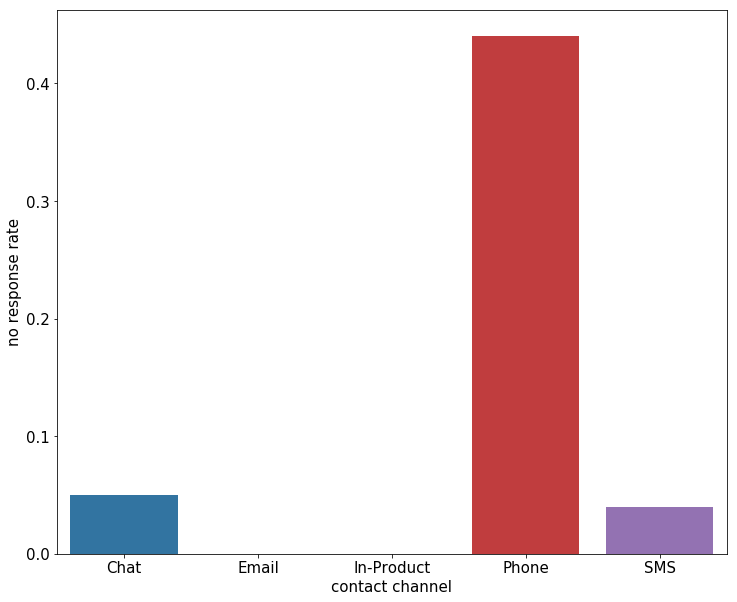

In [466]:
sns.barplot(df_plot.index,df_plot.values)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('contact channel',fontsize=15)
plt.ylabel('no response rate',fontsize=15)

In [18]:
missing_rate(cus_sup_case) # high missing in survey score

post_case_satisfaction_survey_score    0.943089
case_first_response_time               0.092141
case_closed_time                       0.008130
case_created_time                      0.000000
case_subcategory                       0.000000
case_category                          0.000000
case_first_contact_channel             0.000000
case_number                            0.000000
pro_id                                 0.000000
dtype: float64

In [453]:
#create the case length
def transform_date(x):
    if not pd.isnull(x):
        return datetime.strptime(x,'%Y-%m-%d %H:%M:%S')
    else:
        return x
cus_sup_case['case_created_time']=cus_sup_case['case_created_time'].apply(lambda x:transform_date(x))
cus_sup_case['case_closed_time']=cus_sup_case['case_closed_time'].apply(lambda x:transform_date(x))
cus_sup_case['case_first_response_time']=cus_sup_case['case_first_response_time'].apply(lambda x:transform_date(x))

In [218]:
cus_sup_case['case_length']=(cus_sup_case['case_closed_time']-cus_sup_case['case_created_time']).apply(lambda x:x.total_seconds()/3600)

In [219]:
#impute the case_length
cus_sup_case['case_length'].fillna(np.nanmean(cus_sup_case['case_length']),inplace=True)

In [220]:
cus_sup_case['case_length'].describe()

count     369.000000
mean       29.686894
std       112.314520
min         0.000000
25%         0.214167
50%         0.854444
75%        18.592778
max      1729.084167
Name: case_length, dtype: float64

29.686893594414094


D:\Python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


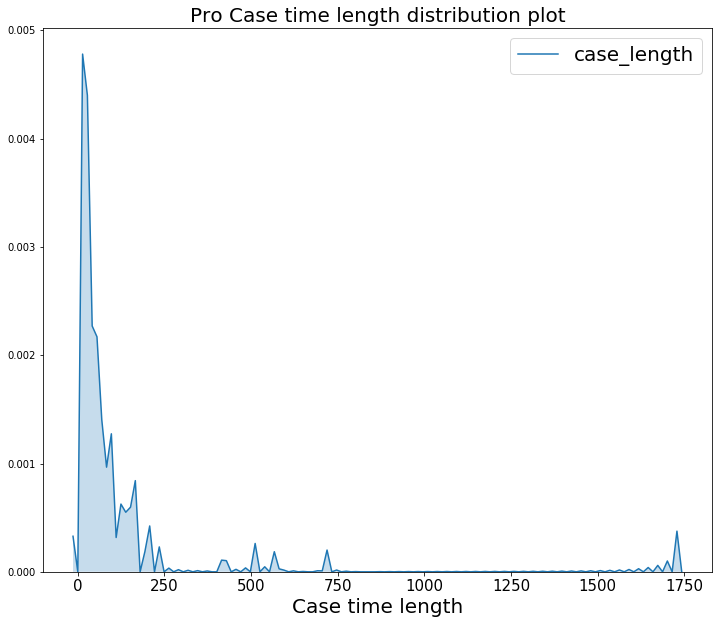

In [234]:
sns.kdeplot(cus_sup_case['case_length'],shade=True,legend=True)
plt.xticks(fontsize=15)
plt.xlabel('Case time length',fontsize=20)
plt.title('Pro Case time length distribution plot',fontsize=20)
print(np.mean(cus_sup_case['case_length']))
plt.legend(prop={'size':20})

In [222]:
#add weekend
# 5 6 are weekend
cus_sup_case['case_weekday']=cus_sup_case['case_created_time'].apply(lambda x:x.weekday())

In [223]:
cus_sup_case['case_is_weekend']=cus_sup_case['case_weekday'].apply(lambda x:1 if x==5 or x==6 else 0)

In [224]:
cus_sup_case.groupby('case_weekday',as_index=False)['pro_id'].count()
cus_sup_week_count['hue']=cus_sup_week_count['case_weekday'].apply(lambda x:1 if x==5 or x==6 else 0)

Text(0.5,1,'Number_case_across_day')

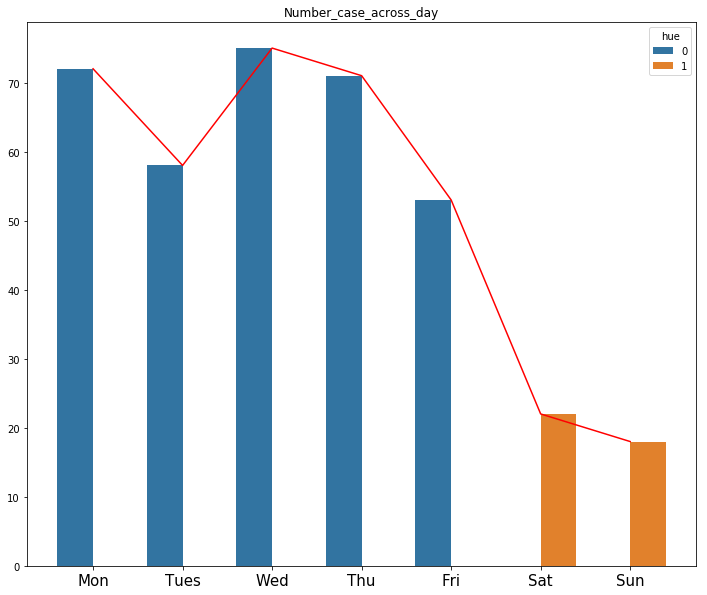

In [226]:
cus_sup_week_count=cus_sup_case.groupby('case_weekday',as_index=False)['pro_id'].count()
cus_sup_week_count['hue']=cus_sup_week_count['case_weekday'].apply(lambda x:1 if x==5 or x==6 else 0)
fig,aes=plt.subplots()
sns.barplot(x=cus_sup_week_count['case_weekday'].values,
            y=cus_sup_week_count['pro_id'].values,ax=aes,hue=cus_sup_week_count['hue'],
               )
aes.set_xticklabels(['Mon','Tues','Wed','Thu','Fri','Sat','Sun'])
plt.xticks(fontsize=15)
plt.plot(cus_sup_week_count['pro_id'].values,'red')
plt.title('Number_case_across_day')

Text(0.5,0,'Case Category')

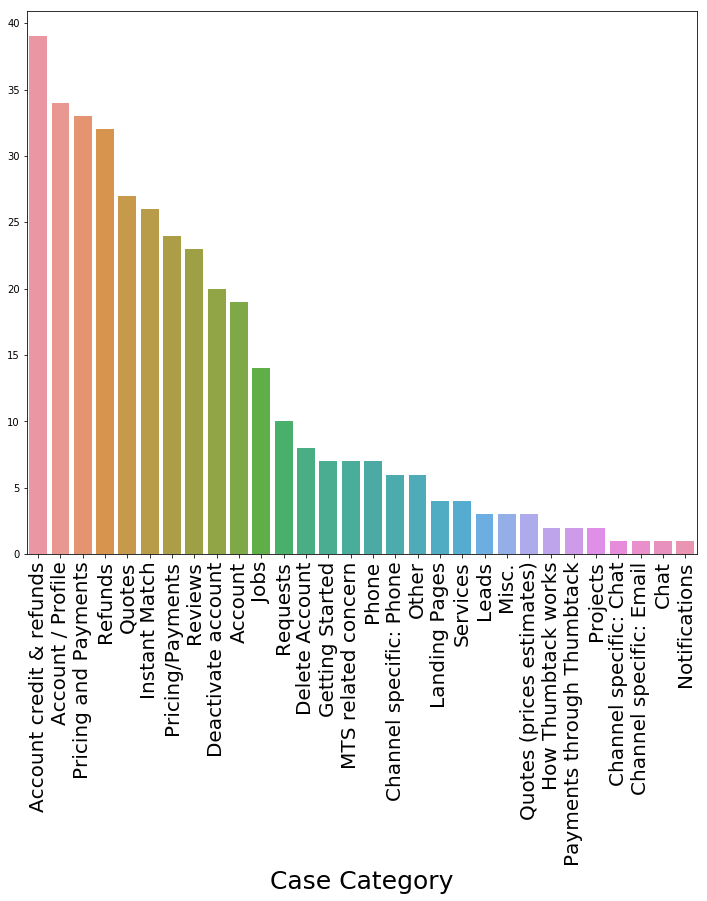

In [227]:
fig,aes=plt.subplots()
C=Counter(cus_sup_case['case_category'])
C_=sorted(C.items(),key=lambda x:x[1],reverse=True)
sns.barplot(x=[z[0] for z in C_],y=[z[1] for z in C_],ax=aes)
plt.xticks(fontsize=20,rotation=90)
plt.xlabel('Case Category',fontsize=25)
# plt.title('Case Category',fontsize=30)

In [450]:
cus_sup_case.groupby(['case_weekday','case_first_contact_channel'])['pro_id'].count()

case_weekday  case_first_contact_channel
0             Chat                           5
              Email                          3
              In-Product                    17
              Phone                         38
              SMS                            9
1             Chat                           2
              Email                          1
              In-Product                    17
              Phone                         27
              SMS                           11
2             Chat                           5
              Email                          3
              In-Product                    13
              Phone                         42
              SMS                           12
3             Chat                           1
              Email                          5
              In-Product                    18
              Phone                         37
              SMS                           10
4             Chat 

In [ ]:
cus_sup_case.groupby(['case_category',''])['pro_id'].count()

Text(0.5,1,'Contact')

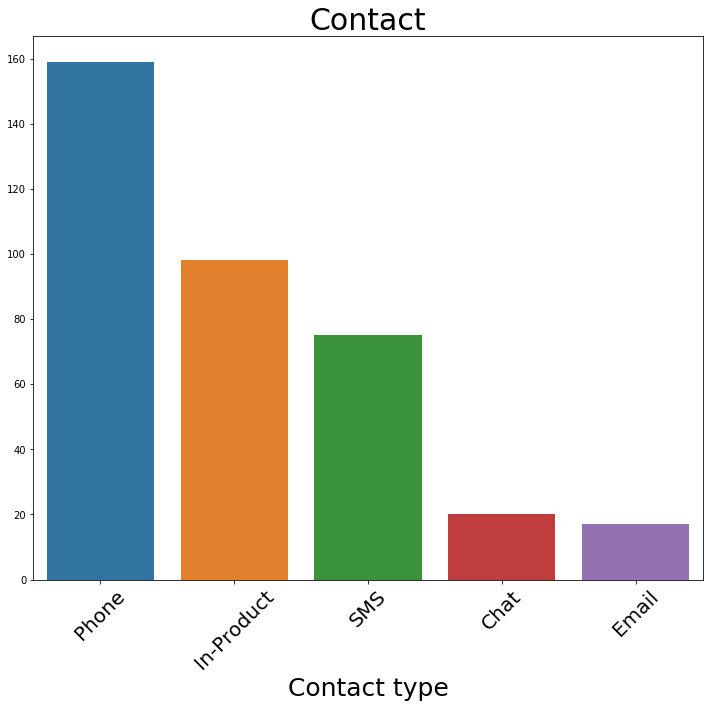

In [444]:
fig,aes=plt.subplots()
C=Counter(cus_sup_case['case_first_contact_channel'])
C_=sorted(C.items(),key=lambda x:x[1],reverse=True)
sns.barplot(x=[z[0] for z in C_],y=[z[1] for z in C_],ax=aes)
plt.xticks(fontsize=20,rotation=45)
plt.xlabel('Contact type',fontsize=25)
plt.title('Contact',fontsize=30)

Text(0,0.5,'# score')

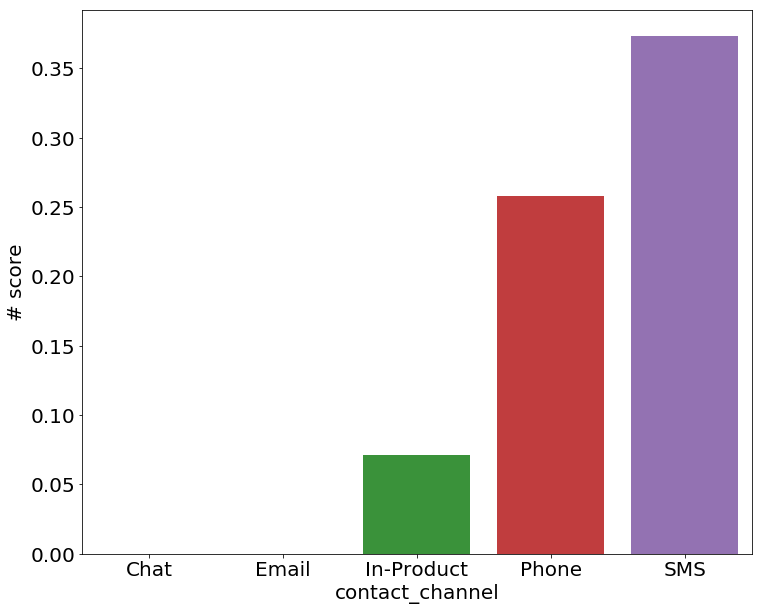

In [440]:
df_plot=cus_sup_case.groupby('case_first_contact_channel',as_index=False)['post_case_satisfaction_survey_score'].mean()
df_plot
sns.barplot('case_first_contact_channel','post_case_satisfaction_survey_score',data=df_plot)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('contact_channel',fontsize=20)
plt.ylabel('# score',fontsize=20)

In [ ]:
df_plot=cus_sup_case.groupby('case_first_contact_channel',as_index=False)['case_length'].mean()
df_plot
sns.barplot('case_first_contact_channel','case_length',data=df_plot)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('contact_channel',fontsize=20)
plt.ylabel('# hour',fontsize=20)

In [229]:
# score
cus_sup_case['post_case_satisfaction_survey_score'].fillna(0,inplace=True)

In [230]:
df_plot=cus_sup_case.groupby('post_case_satisfaction_survey_score',as_index=False).agg({'case_length':'mean','case_category':'count'})
df_plot

,post_case_satisfaction_survey_score,case_length,case_category
0,0.0,30.693478,348
1,1.0,23.523889,5
2,2.0,0.289306,2
3,3.0,0.137778,1
4,4.0,18.246667,1
5,5.0,11.379236,12


KeyError: 'case_length'

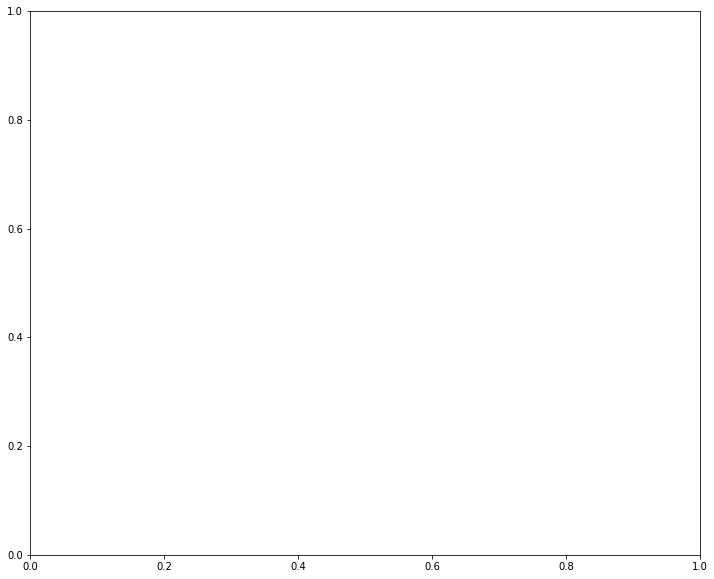

In [443]:
fig,aes=plt.subplots()
# aes.bar(df_plot['post_case_satisfaction_survey_score'],df_plot['case_category'])
sns.barplot(df_plot['post_case_satisfaction_survey_score',df_plot['case_length'],ax=aes)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Score',fontsize=25)
plt.ylabel('Case_length',fontsize=25)
# aes.set_xticklabels(df_plot['post_case_satisfaction_survey_score'])
plt.title('Score_caseLength',fontsize=25)

# Pros


In [258]:
print(pros.shape)
pros.head()

(254, 10)


,pro_id,pro_signup_date,pro_days_in_business,pro_most_quoted_category,pro_num_quotes_lifetime,pro_num_times_contacted_by_customer_lifetime,pro_num_times_marked_hired_lifetime,pro_num_reviews_lifetime,pro_avg_review_rating,token
0,8.848075e+16,2010-10-21 01:59:12,2961,Tree Trimming and Removal,261,73,15,8,4.75,"[tree, trimming, removal]"
1,9.276991e+16,2010-12-09 17:25:14,2912,Sprinkler and Irrigation System Repair and Mai...,418,162,44,43,4.60,"[sprinkler, irrigation, system, repair, mainte..."
2,1.024495e+17,2011-03-31 18:11:16,2800,Lawn Mowing and Trimming,1086,387,160,99,4.79,"[lawn, mowing, trimming]"
3,1.072298e+17,2011-05-26 02:02:49,2744,Concrete Installation,340,79,3,2,3.50,"[concrete, installation]"
4,1.083079e+17,2011-06-07 13:32:29,2732,Lawn Mowing and Trimming,58,31,17,10,5.00,"[lawn, mowing, trimming]"


In [261]:
pd.unique(pros['pro_most_quoted_category'])

array(['Tree Trimming and Removal',
       'Sprinkler and Irrigation System Repair and Maintenance',
       'Lawn Mowing and Trimming', 'Concrete Installation',
       'Outdoor Landscaping and Design', 'Junk Removal', 'Handyman',
       'Weeding', 'Water Feature Repair and Maintenance',
       'Personal Training', 'Snow Plowing',
       'Electrical and Wiring Repair',
       'Holiday Lighting Installation and Removal', 'Demolition Services',
       'Roof Installation or Replacement', 'Framing Carpentry',
       'Fence and Gate Installation', 'Aeration', 'Interior Painting',
       'Land Leveling and Grading', 'Piano Moving', 'Sod Installation',
       'Drywall Repair and Texturing',
       'Sprinkler and Irrigation System Installation',
       'Full Service Lawn Care', 'Window Cleaning', 'House Cleaning',
       'Excavation Services', 'Tree Stump Grinding and Removal',
       'Local Moving (under 50 miles)', 'Gardening',
       'Concrete Repair and Maintenance'], dtype=object)

In [174]:
missing_rate(pros)

pro_avg_review_rating                           0.15748
pro_num_reviews_lifetime                        0.00000
pro_num_times_marked_hired_lifetime             0.00000
pro_num_times_contacted_by_customer_lifetime    0.00000
pro_num_quotes_lifetime                         0.00000
pro_most_quoted_category                        0.00000
pro_days_in_business                            0.00000
pro_signup_date                                 0.00000
pro_id                                          0.00000
dtype: float64

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text yticklabel objects>)

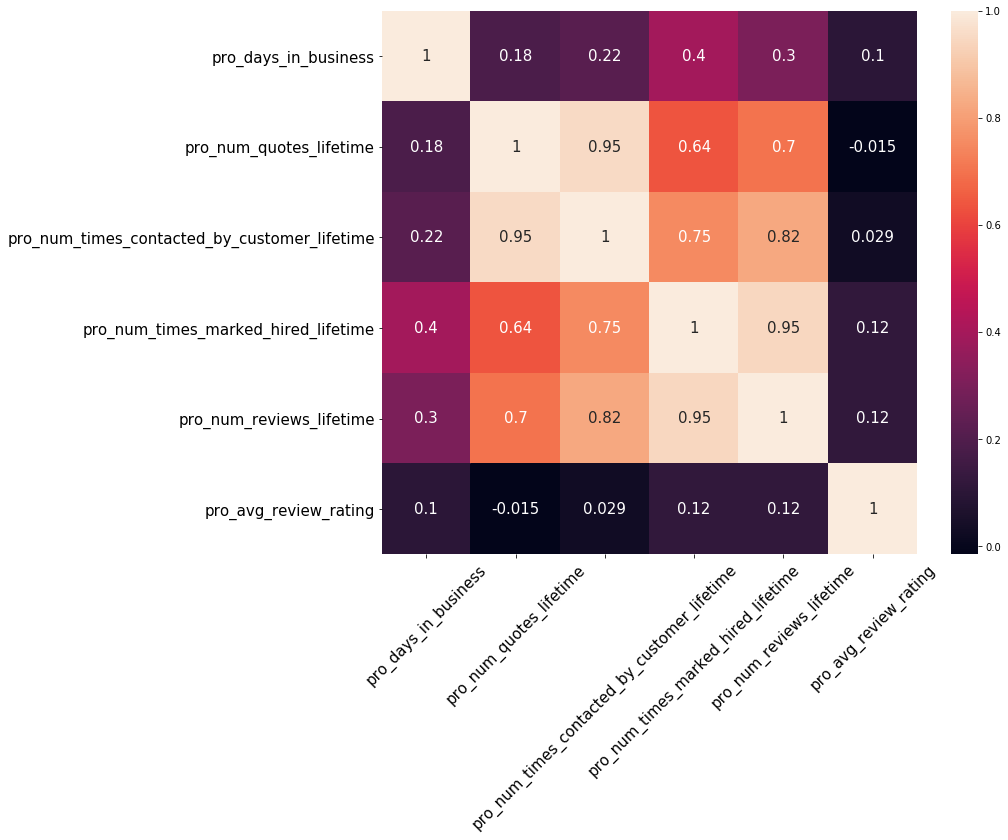

In [249]:
sns.heatmap(pros[['pro_days_in_business','pro_num_quotes_lifetime','pro_num_times_contacted_by_customer_lifetime','pro_num_times_marked_hired_lifetime','pro_num_reviews_lifetime','pro_avg_review_rating']].corr(),annot=True,annot_kws={'size':15})
plt.xticks(fontsize=15,rotation=45)
plt.yticks(fontsize=15)

In [252]:
stop=set(stopwords.words('english'))
Stemmer=PorterStemmer()
def stem(s):
    return Stemmer.stem(s)
Stemmer_=WordNetLemmatizer()
def tokenize(text):
    """parse the item description,
    fileter the stop word and punctuation.
    Lemmatize the word for the sake of normalization
    """
    try:
        regex=re.compile('['+re.escape(string.punctuation)+'0-9\\r\\t\\n]')
        text=regex.sub(' ',text)
        tokens_=word_tokenize(text)
        token=[]
        for token_by in tokens_:
            if token_by not in stop:
                token.append(token_by)
        tokens=list(map(lambda x:x.lower(),token))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [Stemmer_.lemmatize(w.lower()) for w in filtered_tokens]
        return filtered_tokens
    except Exception as e:
        print(e)

In [253]:
pros['token']=pros['pro_most_quoted_category'].apply(lambda x:tokenize(x))

In [266]:
whole_corpus=''
for line in pros['token']:
    if line:
        
        whole_corpus+=' '+' '.join(line)

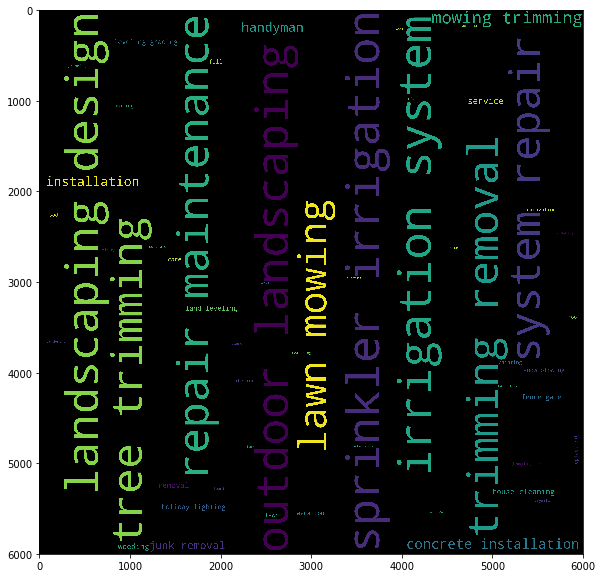

In [269]:
wordcloud=WordCloud(background_color='black',width=6000,height=6000,).generate(whole_corpus,)
plt.imshow(wordcloud)  


# req_quo


In [12]:
print(req_quo.shape)
req_quo.head()

(13448, 19)


,request_id,customer_id,request_create_time,request_category,request_occupation,request_zip_code,request_city,request_state,request_cbsa,quote_id,quote_sent_time,pro_id,quote_type,syndication_type,pro_zip_code,pro_distance_to_request_zip,minutes_from_request_to_quote,pro_contacted_by_customer,thumbtack_revenue_from_quote
0,3.157867e+17,2.643659e+17,2018-01-02 22:32:16,Outdoor Landscaping and Design,Landscaper,84093,Sandy,UT,"Salt Lake City, UT",3.157950e+17,2018-01-03 0:50:34,3.077668e+17,custom,NaN,84044.0,17.280257,138.0,False,0.00
1,3.157867e+17,2.643659e+17,2018-01-02 22:32:16,Outdoor Landscaping and Design,Landscaper,84093,Sandy,UT,"Salt Lake City, UT",3.157878e+17,2018-01-02 22:49:51,2.936746e+17,custom,NaN,84088.0,9.089775,18.0,False,10.02
2,3.157867e+17,2.643659e+17,2018-01-02 22:32:16,Outdoor Landscaping and Design,Landscaper,84093,Sandy,UT,"Salt Lake City, UT",3.157870e+17,2018-01-02 22:35:52,2.541953e+17,custom,NaN,84115.0,9.055618,4.0,False,10.02
3,3.157867e+17,2.643659e+17,2018-01-02 22:32:16,Outdoor Landscaping and Design,Landscaper,84093,Sandy,UT,"Salt Lake City, UT",3.157926e+17,2018-01-03 0:10:29,2.329459e+17,custom,NaN,84065.0,8.050513,98.0,False,0.00
4,3.157867e+17,2.643659e+17,2018-01-02 22:32:16,Outdoor Landscaping and Design,Landscaper,84093,Sandy,UT,"Salt Lake City, UT",3.157867e+17,2018-01-02 22:32:16,3.102338e+17,instant,standard_quote,84090.0,1.815267,0.0,True,53.44


In [19]:
df_plot=req_quo.groupby('request_category',as_index=False)['pro_contacted_by_customer'].count()
df_plot.head()

,request_category,pro_contacted_by_customer
0,Artificial Turf Installation,44
1,Boulder Placement,2
2,Drip Irrigation System Maintenance,10
3,Land Leveling and Grading,207
4,Mulching,15


In [25]:
df_plot1=req_quo.groupby('request_category',as_index=False)['pro_contacted_by_customer'].mean()
df_plot1.head()

,request_category,pro_contacted_by_customer
0,Artificial Turf Installation,0.068182
1,Boulder Placement,1.000000
2,Drip Irrigation System Maintenance,0.500000
3,Land Leveling and Grading,0.396135
4,Mulching,0.533333


In [34]:
a.get_legend_handles_labels()[0][0]

[<BarContainer object of 16 artists>]

AxesSubplot(0.125,0.125;0.775x0.755) [<matplotlib.lines.Line2D object at 0x0000026D17076358>]


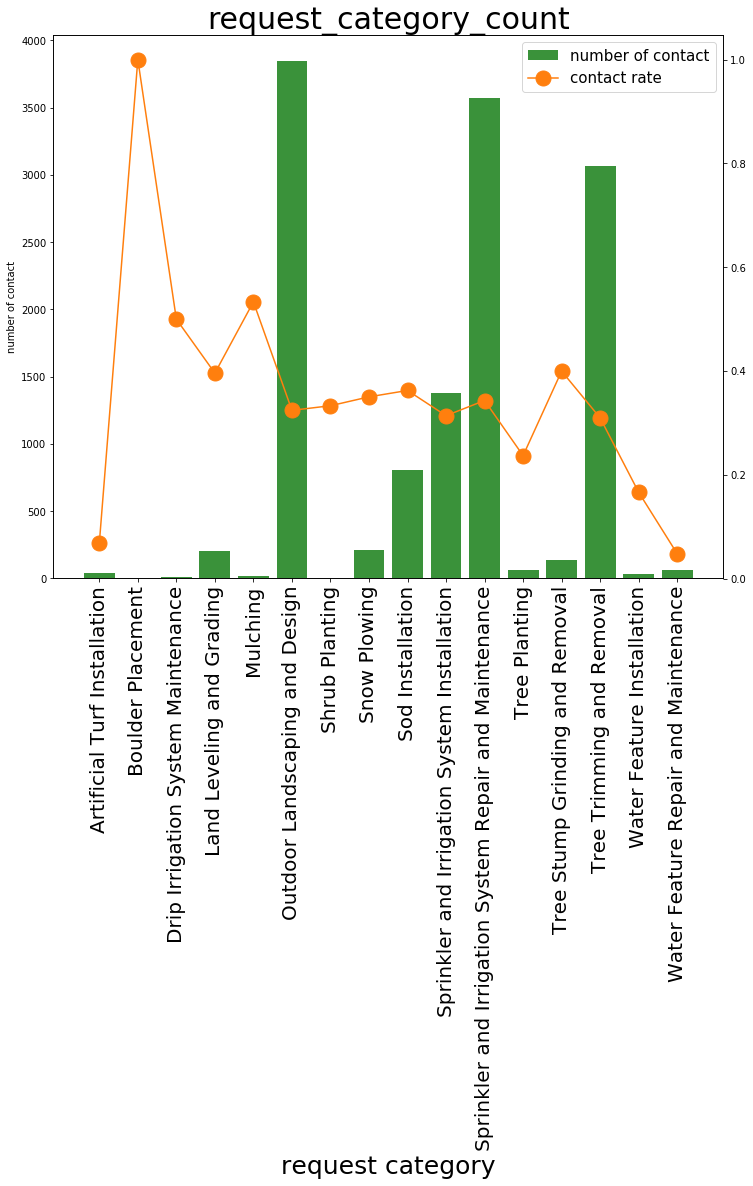

In [44]:
fig,aes=plt.subplots()
a=sns.barplot('request_category','pro_contacted_by_customer',data=df_plot,ax=aes,label='a',color='C2')
plt.xticks(fontsize=20,rotation=90)
plt.xlabel('request category',fontsize=25)
plt.title('request_category_count',fontsize=30)
plt.ylabel('number of contact')
aes1=aes.twinx()
b=aes1.plot(df_plot1['pro_contacted_by_customer'],color='C1',label='b',marker='o',markersize=15)
print(a,b)
plt.legend([a.get_legend_handles_labels()[0][0],b[0]],['number of contact','contact rate'],prop={'size':15})

In [348]:
#add new feature : is there revenue
req_quo['is_revenue']=req_quo['thumbtack_revenue_from_quote']>0

In [354]:
# for different type, the minute
df_plot=req_quo.groupby('quote_type',as_index=False)['minutes_from_request_to_quote','pro_contacted_by_customer','thumbtack_revenue_from_quote','is_revenue'].mean()
df_plot

,quote_type,minutes_from_request_to_quote,pro_contacted_by_customer,thumbtack_revenue_from_quote,is_revenue
0,custom,543.017236,0.348879,4.456192,0.367241
1,instant,0.011450,0.311307,3.141541,0.190363


In [344]:
req_quo.groupby('quote_type')['pro_contacted_by_customer'].mean()

quote_type
custom     0.348879
instant    0.311307
Name: pro_contacted_by_customer, dtype: float64

In [342]:
# pro_distance and minutes_request
req_quo[['minutes_from_request_to_quote','pro_distance_to_request_zip']].corr()

,minutes_from_request_to_quote,pro_distance_to_request_zip
minutes_from_request_to_quote,1.000000,-0.039992
pro_distance_to_request_zip,-0.039992,1.000000


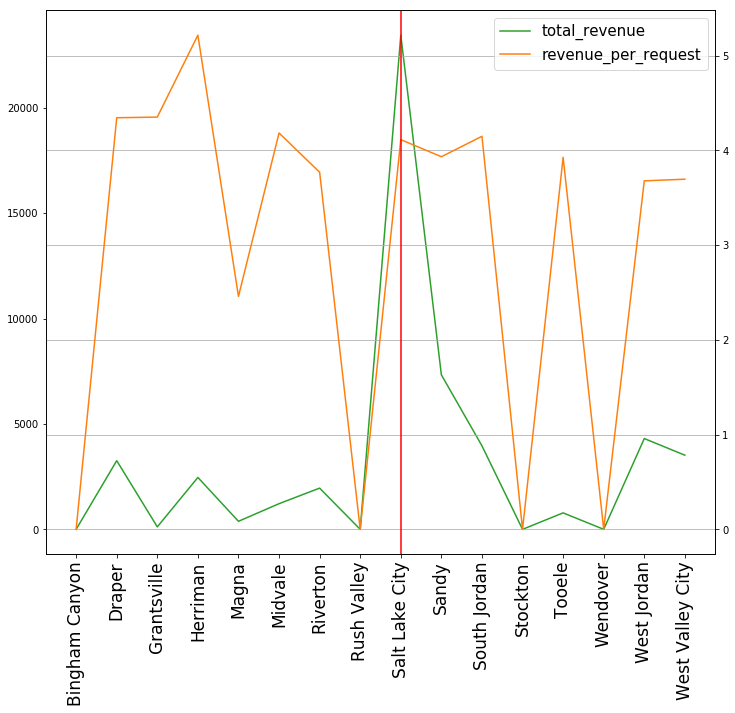

In [324]:
fig,aes=plt.subplots()
a=aes.plot(req_quo.groupby('request_city')['thumbtack_revenue_from_quote'].sum(),color='C2',label='a')
plt.xticks(rotation=90,fontsize=17)
aes1=aes.twinx()
b=aes1.plot(req_quo.groupby('request_city')['thumbtack_revenue_from_quote'].mean().fillna(0),color='C1',label='b')
# aes.set_xticklabels(['']+make_up_col)
# aes1.set_xticklabels(['']+make_up_col_Placebo)


plt.legend([a[0],b[0]],['total_revenue','revenue_per_request'],prop={'size':15})
# plt.xticks(rotation=45,fontsize=20)
plt.grid()
plt.axvline(8,color='r')

In [273]:
req_quo['request_create_time']=req_quo['request_create_time'].apply(lambda x:transform_date(x))
req_quo['quote_sent_time']=req_quo['quote_sent_time'].apply(lambda x:transform_date(x))

In [274]:
req_quo['request_quote']=(req_quo['request_create_time']-req_quo['quote_sent_time']).apply(lambda x:x.total_seconds()/3600)

In [281]:
req_quo['discrete_request_create_time']=req_quo['request_create_time'].apply(lambda x:x.hour)

Text(0,0.5,'# request')

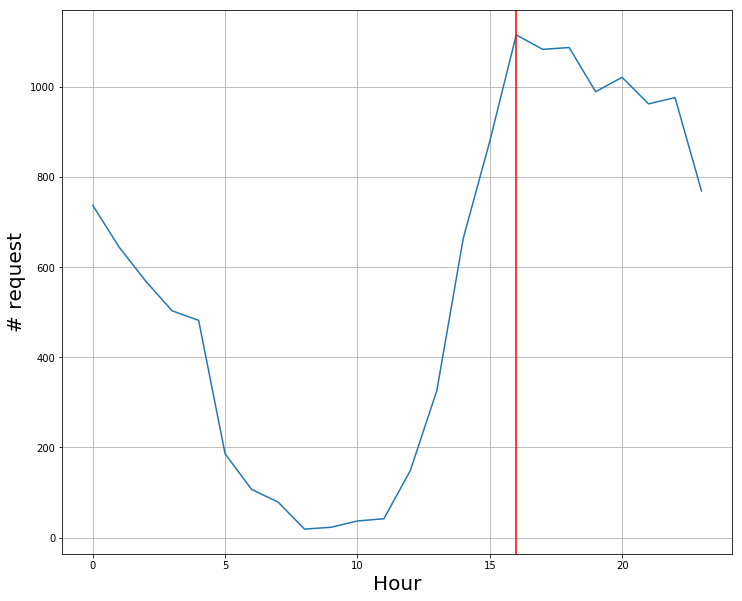

In [325]:
plt.plot(req_quo.groupby('discrete_request_create_time')['customer_id'].count())
plt.grid()
plt.axvline(16,color='r')
plt.xlabel('Hour',fontsize=20)
plt.ylabel('# request',fontsize=20)

D:\Python\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


16

In [339]:
def plot_req_hour_city(data,city):
    df_plot=data[data['request_city']==city]
    plt.plot(df_plot.groupby('discrete_request_create_time')['customer_id'].count())
    plt.grid()
    plt.axvline(np.argmax(df_plot.groupby('discrete_request_create_time')['customer_id'].count()),color='r')
    plt.xlabel('Hour',fontsize=20)
    plt.ylabel('# request',fontsize=20)
    plt.title(city,fontsize=20)

D:\Python\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


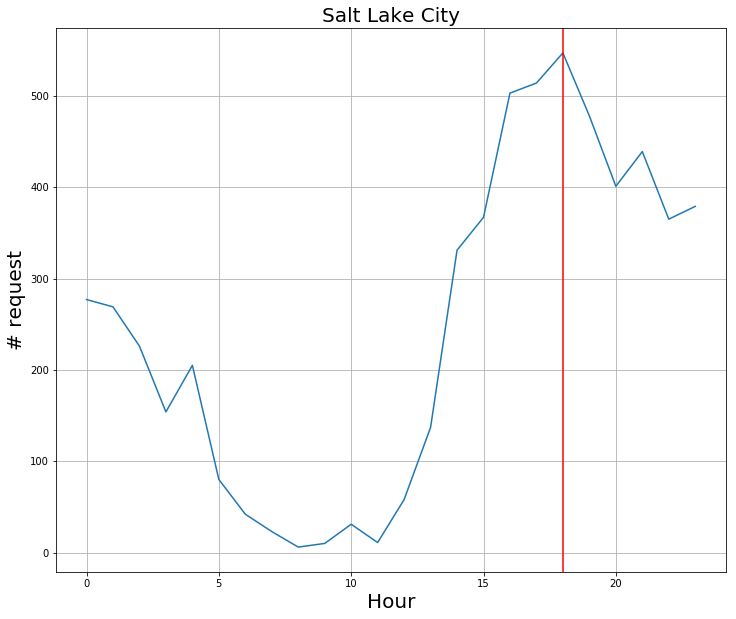

In [340]:
plot_req_hour_city(req_quo,'Salt Lake City')

D:\Python\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


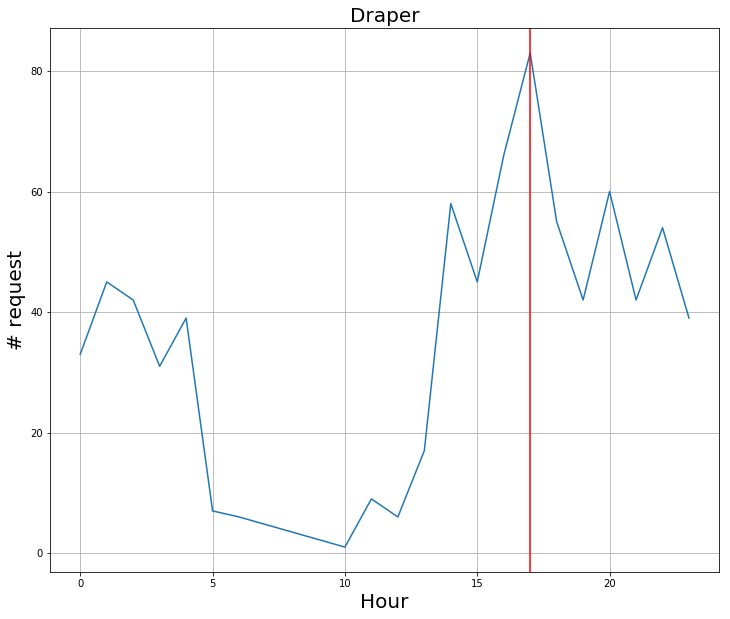

In [341]:
plot_req_hour_city(req_quo,'Draper')

In [271]:
missing_ratesing_rate(req_quo)

syndication_type                 0.688281
thumbtack_revenue_from_quote     0.028183
quote_sent_time                  0.028183
pro_id                           0.028183
quote_type                       0.028183
quote_id                         0.028183
pro_zip_code                     0.028183
pro_distance_to_request_zip      0.028183
minutes_from_request_to_quote    0.028183
pro_contacted_by_customer        0.000000
request_cbsa                     0.000000
request_state                    0.000000
request_city                     0.000000
request_zip_code                 0.000000
request_occupation               0.000000
request_category                 0.000000
request_create_time              0.000000
customer_id                      0.000000
request_id                       0.000000
dtype: float64

# data integration

In [486]:
df_train=pd.merge(left=req_quo,right=pros,on='pro_id',how='left')

In [366]:
# df_train=pd.merge(left=df_train,right=cus_sup_case,on='pro_id')

In [487]:
df_train.head()

,request_id,customer_id,request_create_time,request_category,request_occupation,request_zip_code,request_city,request_state,request_cbsa,quote_id,...,is_revenue,pro_signup_date,pro_days_in_business,pro_most_quoted_category,pro_num_quotes_lifetime,pro_num_times_contacted_by_customer_lifetime,pro_num_times_marked_hired_lifetime,pro_num_reviews_lifetime,pro_avg_review_rating,token
0,3.157867e+17,2.643659e+17,2018-01-02 22:32:16,Outdoor Landscaping and Design,Landscaper,84093,Sandy,UT,"Salt Lake City, UT",3.157950e+17,...,False,2017-10-02 02:46:11,423.0,Concrete Installation,776.0,178.0,10.0,10.0,3.80,"[concrete, installation]"
1,3.157867e+17,2.643659e+17,2018-01-02 22:32:16,Outdoor Landscaping and Design,Landscaper,84093,Sandy,UT,"Salt Lake City, UT",3.157878e+17,...,True,2017-04-22 00:17:21,586.0,Lawn Mowing and Trimming,195.0,69.0,16.0,13.0,4.69,"[lawn, mowing, trimming]"
2,3.157867e+17,2.643659e+17,2018-01-02 22:32:16,Outdoor Landscaping and Design,Landscaper,84093,Sandy,UT,"Salt Lake City, UT",3.157870e+17,...,True,2016-01-21 01:48:17,1043.0,Outdoor Landscaping and Design,902.0,278.0,51.0,43.0,4.77,"[outdoor, landscaping, design]"
3,3.157867e+17,2.643659e+17,2018-01-02 22:32:16,Outdoor Landscaping and Design,Landscaper,84093,Sandy,UT,"Salt Lake City, UT",3.157926e+17,...,False,2015-05-20 03:11:46,1289.0,Outdoor Landscaping and Design,1396.0,533.0,109.0,82.0,4.66,"[outdoor, landscaping, design]"
4,3.157867e+17,2.643659e+17,2018-01-02 22:32:16,Outdoor Landscaping and Design,Landscaper,84093,Sandy,UT,"Salt Lake City, UT",3.157867e+17,...,True,2017-10-30 16:03:44,395.0,Outdoor Landscaping and Design,221.0,46.0,1.0,2.0,3.00,"[outdoor, landscaping, design]"


In [488]:
df_train['is_match']=df_train['request_category']==df_train['pro_most_quoted_category']

In [493]:
df_train.columns

Index(['request_city', 'quote_type', 'syndication_type',
       'pro_distance_to_request_zip', 'minutes_from_request_to_quote',
       'pro_contacted_by_customer', 'thumbtack_revenue_from_quote',
       'request_quote', 'discrete_request_create_time', 'is_revenue',
       'pro_days_in_business', 'pro_num_quotes_lifetime',
       'pro_num_times_contacted_by_customer_lifetime',
       'pro_num_times_marked_hired_lifetime', 'pro_num_reviews_lifetime',
       'pro_avg_review_rating', 'is_match'],
      dtype='object')

In [489]:
columns_to_drop1=['request_create_time','request_zip_code','request_state','request_cbsa','quote_id','request_id','customer_id']

In [490]:
df_train.drop(columns=columns_to_drop1,inplace=True)

In [491]:
columns_to_drop2=['quote_sent_time','pro_id','pro_zip_code','request_occupation','is_revence', 'pro_signup_date','token','request_category','pro_most_quoted_category']

In [492]:
df_train.drop(columns=columns_to_drop2,inplace=True)

### model

In [400]:
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,cross_val_score
import xgboost
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

In [403]:
KF=KFold(5)

In [386]:
Counter(df_train['syndication_type'])

Counter({nan: 22696,
         'standard_quote': 5618,
         'broad_matching': 178,
         'budget_overserving_quote': 1614,
         'instant_results_direct_contact_custom': 415,
         'nearby_geo_quote': 571,
         'instant_results_direct_contact_instant': 6,
         'instant_results_fuzzy_match_contact_instant': 4})

In [501]:
missing_rate(df_train)

minutes_from_request_to_quote                   0.028183
pro_num_reviews_lifetime                        0.028183
pro_num_times_marked_hired_lifetime             0.028183
pro_num_times_contacted_by_customer_lifetime    0.028183
pro_num_quotes_lifetime                         0.028183
pro_days_in_business                            0.028183
quote_type                                      0.028183
request_quote                                   0.028183
thumbtack_revenue_from_quote                    0.028183
pro_distance_to_request_zip                     0.028183
is_match                                        0.000000
syndication_type                                0.000000
discrete_request_create_time                    0.000000
pro_contacted_by_customer                       0.000000
pro_avg_review_rating                           0.000000
is_revenue                                      0.000000
request_city                                    0.000000
dtype: float64

In [504]:
df_train.dropna(inplace=True)

In [505]:
df_train['syndication_type'].fillna('standard_quote',inplace=True)

In [506]:
df_train['pro_avg_review_rating'].fillna(np.nanmean(df_train['pro_avg_review_rating']),inplace=True)

In [507]:
LB=LabelEncoder()
for col in df_train.select_dtypes(include='O').columns:
    df_train[col]=LB.fit_transform(df_train[col])

In [508]:
df_train.columns

Index(['request_city', 'quote_type', 'syndication_type',
       'pro_distance_to_request_zip', 'minutes_from_request_to_quote',
       'pro_contacted_by_customer', 'thumbtack_revenue_from_quote',
       'request_quote', 'discrete_request_create_time', 'is_revenue',
       'pro_days_in_business', 'pro_num_quotes_lifetime',
       'pro_num_times_contacted_by_customer_lifetime',
       'pro_num_times_marked_hired_lifetime', 'pro_num_reviews_lifetime',
       'pro_avg_review_rating', 'is_match'],
      dtype='object')

In [394]:
LR=LogisticRegression(penalty='l1')

In [395]:
X=df_train.drop(columns=['is_revenue','thumbtack_revenue_from_quote'])

In [396]:
Y=df_train['is_revenue']

In [423]:
cross_val_score(LR,X,Y,cv=KF)

D:\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.88908536, 0.84552323, 0.91495177, 0.95048232, 0.90466238])

In [405]:
CLF=xgboost.XGBClassifier(n_estimators=300)

In [406]:
cross_val_score(CLF,X,Y,cv=KF)

array([0.88779939, 0.85966886, 0.89758842, 0.95787781, 0.92491961])

In [413]:
CLF=GradientBoostingClassifier()
CLF.fit(X,Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [410]:
CLF.feature_importances_
cross_val_score(CLF,X,Y,cv=KF)

array([0.88988909, 0.85661469, 0.91800643, 0.95948553, 0.95176849])

In [417]:
df_plot=pd.DataFrame({'Score':CLF.feature_importances_,'Feature':list(X.columns)})

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 <a list of 23 Text xticklabel objects>)

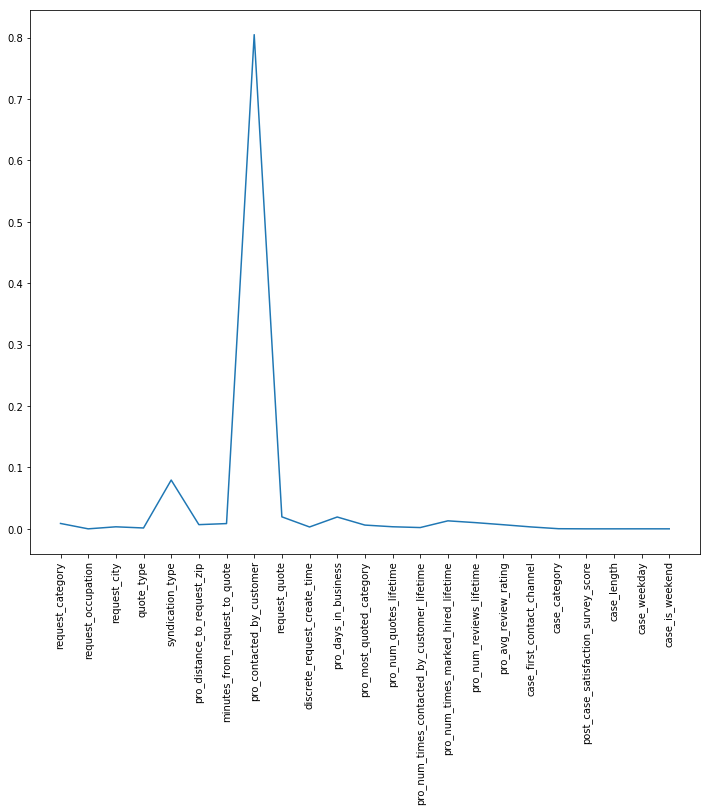

In [422]:
plt.plot(df_plot['Feature'],df_plot['Score'])
plt.xticks(rotation=90)

In [494]:
df_train.columns

Index(['request_city', 'quote_type', 'syndication_type',
       'pro_distance_to_request_zip', 'minutes_from_request_to_quote',
       'pro_contacted_by_customer', 'thumbtack_revenue_from_quote',
       'request_quote', 'discrete_request_create_time', 'is_revenue',
       'pro_days_in_business', 'pro_num_quotes_lifetime',
       'pro_num_times_contacted_by_customer_lifetime',
       'pro_num_times_marked_hired_lifetime', 'pro_num_reviews_lifetime',
       'pro_avg_review_rating', 'is_match'],
      dtype='object')

In [525]:
X=df_train.drop(columns=['is_revenue','thumbtack_revenue_from_quote','pro_contacted_by_customer'])

In [526]:
Y=df_train['pro_contacted_by_customer']

In [527]:
CLF=xgboost.XGBClassifier(n_estimators=300)

In [528]:
cross_val_score(CLF,X,Y,cv=KF)

array([0.67903596, 0.60405509, 0.68247896, 0.67482785, 0.67891313])

In [529]:
CLF.fit(X,Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [530]:
df_plot=pd.DataFrame({'Score':CLF.feature_importances_,'Feature':list(X.columns)})

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text xticklabel objects>)

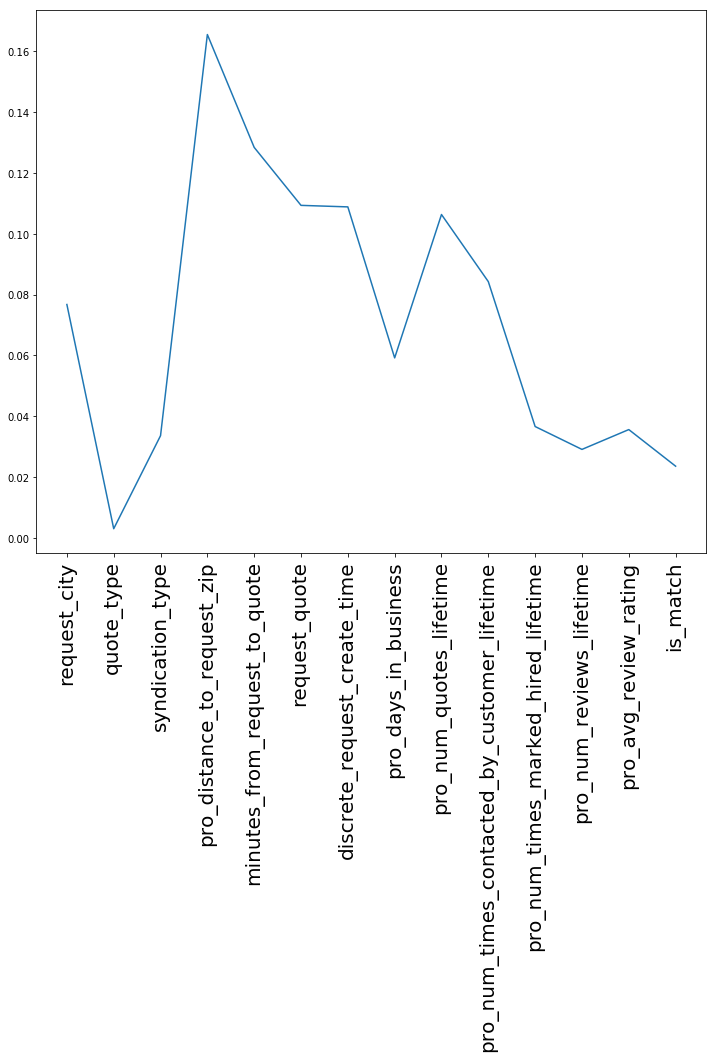

In [531]:
plt.plot(df_plot['Feature'],df_plot['Score'])
plt.xticks(rotation=90,fontsize=20)

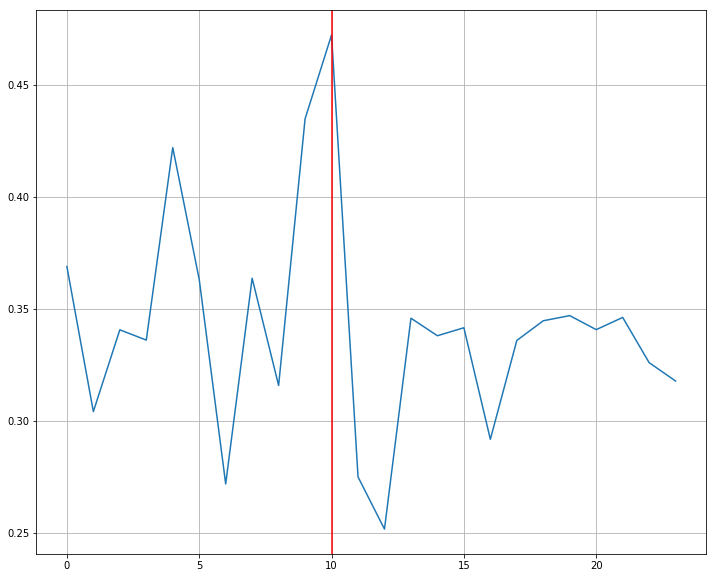

In [539]:
plt.plot(df_train.groupby('discrete_request_create_time')['pro_contacted_by_customer'].mean())
plt.axvline(x=10,color='r')
plt.grid()